In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import time as time

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-stock-data/GOOGL.csv


In [2]:
!pip install -q pmdarima ## auto arima module
!pip install -q pykan  ## KAN module
!pip install -q lightning  ## Lightning AI module for torch

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from kan import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD

from scipy import stats

import lightning as L

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,LSTM, Dense, Dropout, TimeDistributed, Attention, Permute, Reshape, Multiply, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping # Optional: To stop training early

## Data Processing and Analysis

In [4]:
df_goog = pd.read_csv('/kaggle/input/google-stock-data/GOOGL.csv')
print(f'shape of the data: {df_goog.shape}')
df_goog.head()

shape of the data: (4431, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


#### Let's take a look at the data type of every columns and ensure they are in correct format for our analysis.

In [5]:
df_goog.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

#### The only modification we would need to do is to change the Date column to a pandas datetime object.

In [6]:
df_goog.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### The data do not contain any NaN values, hence we do not need to clean any further. Since the Adjusted Close is same as the Close value of the stock, we drop the column 'Adj Close' in the next. Also, we convert the Date column into a numpy datettime array.

In [7]:
df = df_goog.drop('Adj Close',axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,9188602


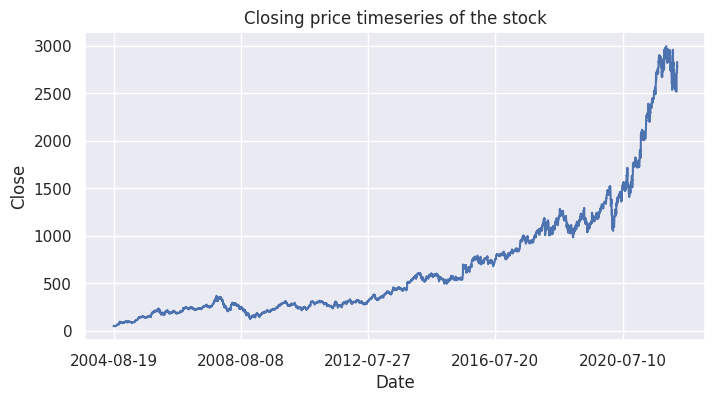

In [8]:
sns.set(context='notebook',style='darkgrid')

fig,ax = plt.subplots(1,1,figsize=(8,4))

sns.lineplot(data=df,x='Date',y='Close',ax=ax)

ax.set(xticks=df['Date'].iloc[::1000],title='Closing price timeseries of the stock')

plt.show()

#### For the analysis, we create some additional columns to calculate the daily change, return and log return of the closing price of the stock.

In [9]:
df['Daily Change'] = df['Close'].diff()
df['Return'] = df['Close'] / df['Close'].shift(1)
df['Log Return'] = np.log(df['Return'])
df.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,44659096,NaN,NaN,NaN
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,22834343,3.988990,1.079430,0.076433
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,18256126,0.545544,1.010064,0.010013
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,15247337,-2.267265,0.958592,-0.042289
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,9188602,0.565567,1.010775,0.010718


In [10]:
## Remove the NaN value in the first row.

df = df.iloc[1:,:].reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return
0,2004-08-20,50.555557,54.594597,50.300301,54.209209,22834343,3.988990,1.079430,0.076433
1,2004-08-23,55.430431,56.796799,54.579578,54.754753,18256126,0.545544,1.010064,0.010013
2,2004-08-24,55.675674,55.855858,51.836838,52.487488,15247337,-2.267265,0.958592,-0.042289
3,2004-08-25,52.532532,54.054054,51.991993,53.053055,9188602,0.565567,1.010775,0.010718
4,2004-08-26,52.527527,54.029030,52.382381,54.009010,7094898,0.955955,1.018019,0.017858


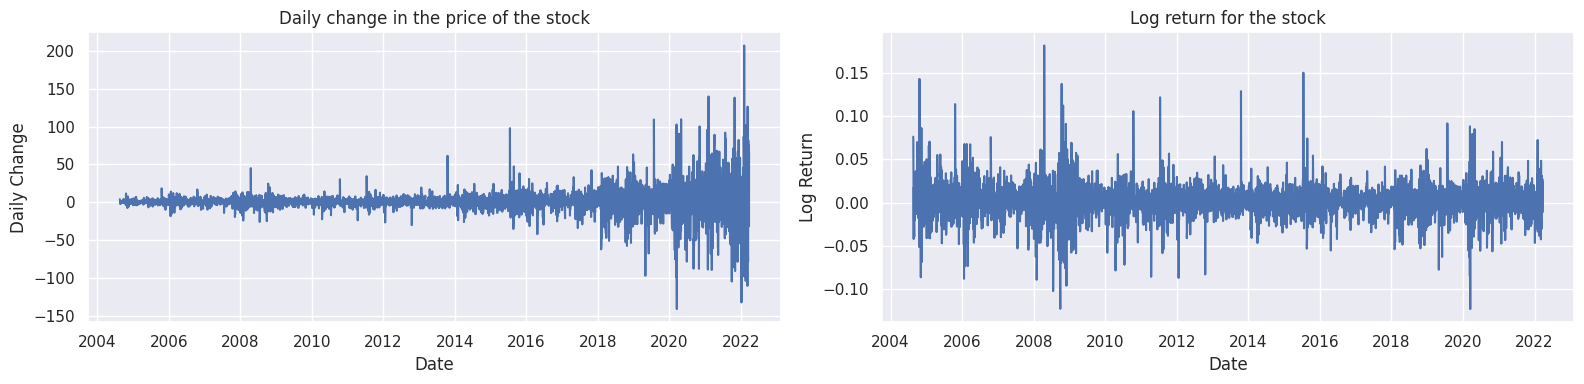

In [11]:
sns.set(context='notebook',style='darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df,x='Date',y='Daily Change',ax=ax[0])
sns.lineplot(data=df,x='Date',y='Log Return',ax=ax[1])

ax[0].set(title='Daily change in the price of the stock')
ax[1].set(title='Log return for the stock')

plt.tight_layout()
plt.show()

### From the plot of the log return above, we can identify one highly volatile period, which is around $2008$, due to the world economic crisis. For the analysis in this notebook, we only consider data post 2010, as the effect of the crisis was also prevalent in $2009$. Additionally, the daily change of the closing price shows high volatility post 2020 and hence for the suitability for the ARIMA model, we restrict the data also to $2020$.

## ARIMA on selected era

In [12]:
era_mask = (df['Date'].dt.year >= 2010) & (df['Date'].dt.year < 2020)

df_era = df[era_mask].reset_index(drop=True)

print(f'shape of the data is: {df_era.shape}')
df_era.head()

shape of the data is: (2516, 9)


,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return
0,2010-01-04,313.788788,315.070068,312.432434,313.688690,3908488,3.388397,1.010920,0.010861
1,2010-01-05,313.903900,314.234222,311.081085,312.307312,6003391,-1.381378,0.995596,-0.004413
2,2010-01-06,313.243256,313.243256,303.483490,304.434448,7949443,-7.872864,0.974791,-0.025532
3,2010-01-07,305.005005,305.305298,296.621613,297.347351,12815771,-7.087097,0.976720,-0.023555
4,2010-01-08,296.296295,301.926941,294.849854,301.311310,9439151,3.963959,1.013331,0.013243


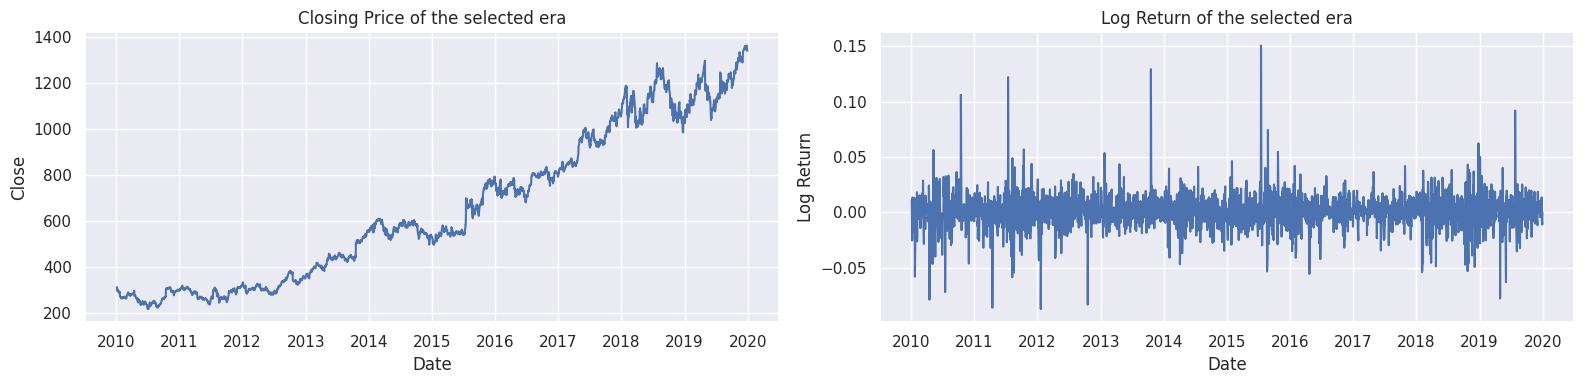

In [14]:
sns.set(context='notebook',style='darkgrid')

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_era,x='Date',y='Close',ax=ax0)
sns.lineplot(data=df_era,x='Date',y='Log Return',ax=ax1)

ax0.set(title='Closing Price of the selected era')
ax1.set(title='Log Return of the selected era')

plt.tight_layout()
plt.show()

#### For the comparison of the prediction from different models, we define a mean-square loss below. One can also use other losses.

In [15]:
def mse_loss(y_true,y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

df_copy = df_era.copy() ## A copy of the actual data is used, so that the original remains unharmed

#### Next, we run a loop over a set of choices for the train-test split ratios. For each of them, we fit an ARIMA model on the training set using the auto arima method from the pmdarima module which we have imported as pm. Then we measure the mean-square loss for the corresponding test sets to compare and find out the optimum train-test ratio.

In [45]:
split_ratios = np.arange(0.6,0.91,0.05)

loss_dict = {}

for split_ratio in split_ratios:
    split_indx = int(df_copy.shape[0]*split_ratio)

    df_train = df_copy['Close'].iloc[:split_indx]
    df_test = df_copy['Close'].iloc[split_indx:]

    auto_arima = pm.auto_arima(df_train,stepwise=False,seasonal=False)
    forecast_auto = auto_arima.predict(n_periods=len(df_test))

    mse_loss_val = mse_loss(df_test,forecast_auto)
    loss_dict[split_ratio] = mse_loss_val

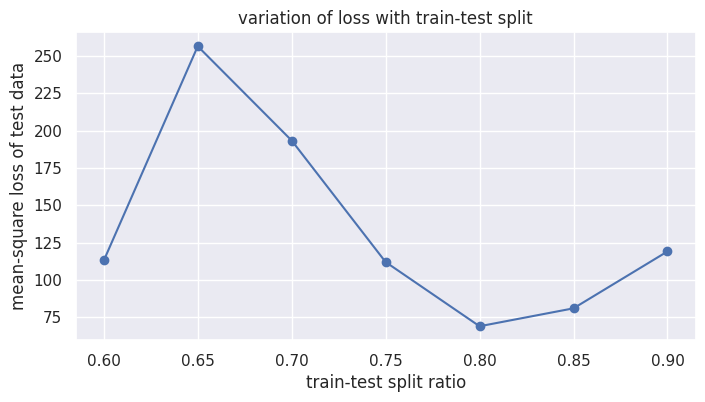

In [46]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(split_ratios,list(loss_dict.values()),'-o',markersize=6)

ax.set(xlabel='train-test split ratio',ylabel='mean-square loss of test data',title='variation of loss with train-test split')

plt.show()

#### Since, the test loss is minimum at $0.8$, we identify $0.8$ as the optimum train-test ratio for our subsequent analysis. Next, we look at the closing price and the daily change of the closing price of the stock.

In [16]:
optimum_split_ratio = 0.8
split_index = int(df_copy.shape[0]*optimum_split_ratio)

train_arima = df_copy['Close'].iloc[:split_index]
test_arima = df_copy['Close'].iloc[split_index:]

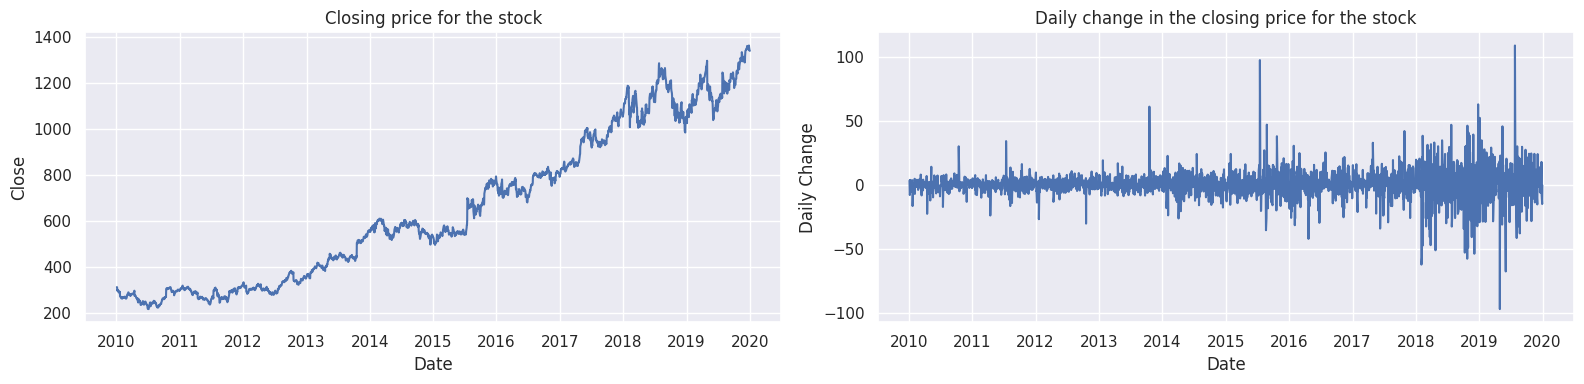

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_copy,x='Date',y='Close',ax=ax[0])
sns.lineplot(data=df_copy,x='Date',y='Daily Change',ax=ax[1])

ax[0].set(title='Closing price for the stock')
ax[1].set(title='Daily change in the closing price for the stock')

plt.tight_layout()
plt.show()

#### The daily change, which is the first difference of the closing price appears stationary and without any bias. Hence a suitable ARIMA model should be of the form $(m,1,n)$. We find the $m, n$ from the Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF) plots.

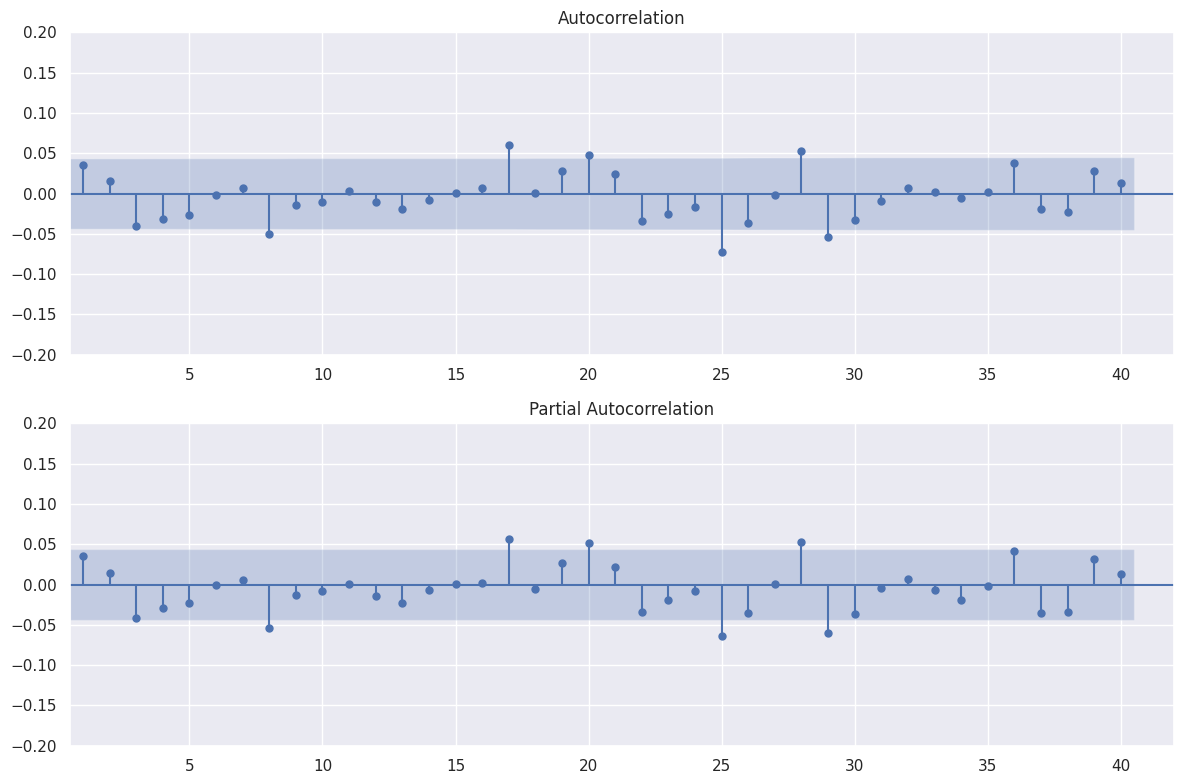

In [19]:
feature = 'Daily Change'

fig = plt.figure(figsize=(12, 8))
ax0 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_copy[feature].iloc[1:split_index], lags=40, ax=ax0)
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_copy[feature].iloc[1:split_index], lags=40, ax=ax1)

ax0.set(xlim=[0.5,42],ylim=[-0.2,0.2])
ax1.set(xlim=[0.5,42],ylim=[-0.2,0.2])

plt.tight_layout()
plt.show()

#### For this particular timeseries, we can not see any clear order from the correlation. Both the ACF and PACF follows similar pattern and falls below the significance band. However, to make an estimate we can note that the PACF hits zero at the 6th node and hence we try to fit an ARIMA(5,1,0) as an initial guess and compare it with the results of autoarima module.

In [18]:
model_arima = ARIMA(train_arima,order=(5,1,0)).fit()
model_auto_arima = pm.auto_arima(train_arima,stepwise=False,seasonal=False)
predictions_arima = model_arima.forecast(steps=len(test_arima))
predictions_auto_arima = model_auto_arima.predict(n_periods=len(test_arima))

In [19]:
model_auto_arima

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True)

#### The autoarima module fits an ARIMA(1,1,3)

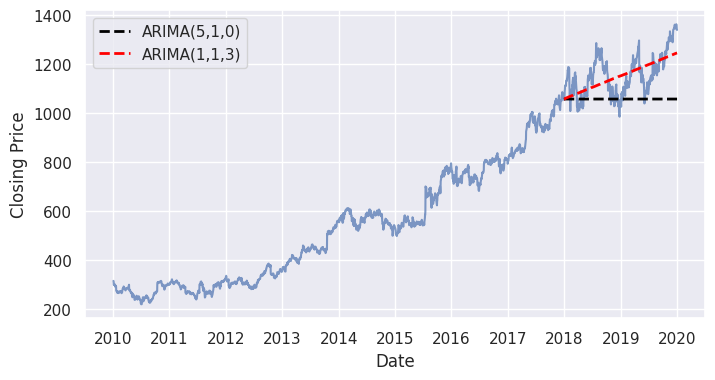

In [29]:
plt.figure(figsize=(8,4))

plt.plot(df_copy['Date'],df_copy['Close'],alpha=0.7)
plt.plot(df_copy['Date'].iloc[split_index:], predictions_arima,ls='dashed',lw=2,color='black',label='ARIMA(5,1,0)')
plt.plot(df_copy['Date'].iloc[split_index:], predictions_auto_arima,ls='dashed',lw=2,color='red',label='ARIMA(1,1,3)')

plt.gca().set(xlabel='Date',ylabel='Closing Price')
plt.legend()

plt.show()

#### In terms of performance, the ARIMA(1,1,3) does a much better job than the ARIMA(5,1,0) and captures the upward trend of the price. However, it is unable to predict the short term ups and downs in the timeseries. We quantify the performances by computing the mean-square error.

In [40]:
loss_ARIMA = mse_loss(test_arima,predictions_arima)
loss_auto_ARIMA = mse_loss(test_arima,predictions_auto_arima)

print(f'The error in the ARIMA(5,1,0) model : {loss_ARIMA}')
print(f'The error in the ARIMA(1,1,3) model : {loss_auto_ARIMA}')

The error in the ARIMA(5,1,0) model : 129.3071873767055
The error in the ARIMA(1,1,3) model : 69.00767548856808


#### Since the ARIMA do not seem to capture the short-term fluctuations well, we try to model a smoothened timeseries with it, rather than the highly fluctuating daily price curve. One can obtain these by using a Simple Moving Average (SMA) or an Exponential Moving Average (EMA). Since, the EMA do not cause any loss of data, we will proceed with the EMA timeseries for our analysis.

### ARIMA on rolling average

In [30]:
df_copy['SMA(12)'] = df_copy['Close'].rolling(window=12).mean()
df_copy['EMA'] = df_copy['Close'].ewm(span=20,adjust=True).mean()
df_copy.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return,SMA(12),EMA
0,2010-01-04,313.788788,315.070068,312.432434,313.688690,3908488,3.388397,1.010920,0.010861,NaN,313.688690
1,2010-01-05,313.903900,314.234222,311.081085,312.307312,6003391,-1.381378,0.995596,-0.004413,NaN,312.963467
2,2010-01-06,313.243256,313.243256,303.483490,304.434448,7949443,-7.872864,0.974791,-0.025532,NaN,309.831662
3,2010-01-07,305.005005,305.305298,296.621613,297.347351,12815771,-7.087097,0.976720,-0.023555,NaN,306.227634
4,2010-01-08,296.296295,301.926941,294.849854,301.311310,9439151,3.963959,1.013331,0.013243,NaN,305.038417


#### We look at the EMA timeseries and its first difference.

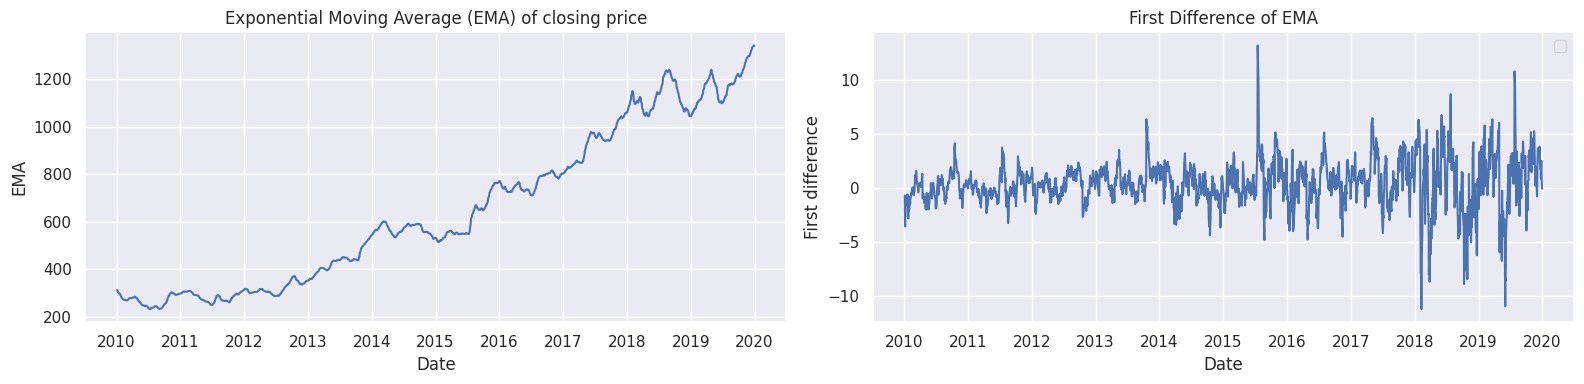

In [31]:
df_copy['EMA first diff'] = df_copy['EMA'].diff()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_copy,x='Date',y='EMA',ax=ax0)
sns.lineplot(data=df_copy,x='Date',y=df_copy['EMA first diff'],ax=ax1)

ax0.set(title='Exponential Moving Average (EMA) of closing price')
ax1.set(ylabel='First difference',title='First Difference of EMA')

plt.legend()

plt.tight_layout()
plt.show()

#### Both the EMA and its first difference can be considered as stationary. The EMA has clear upward bias and the first difference seems to have some seasonal oscillation in the fluctuations, which are not random. Hence, we need to look at the second difference of EMA.

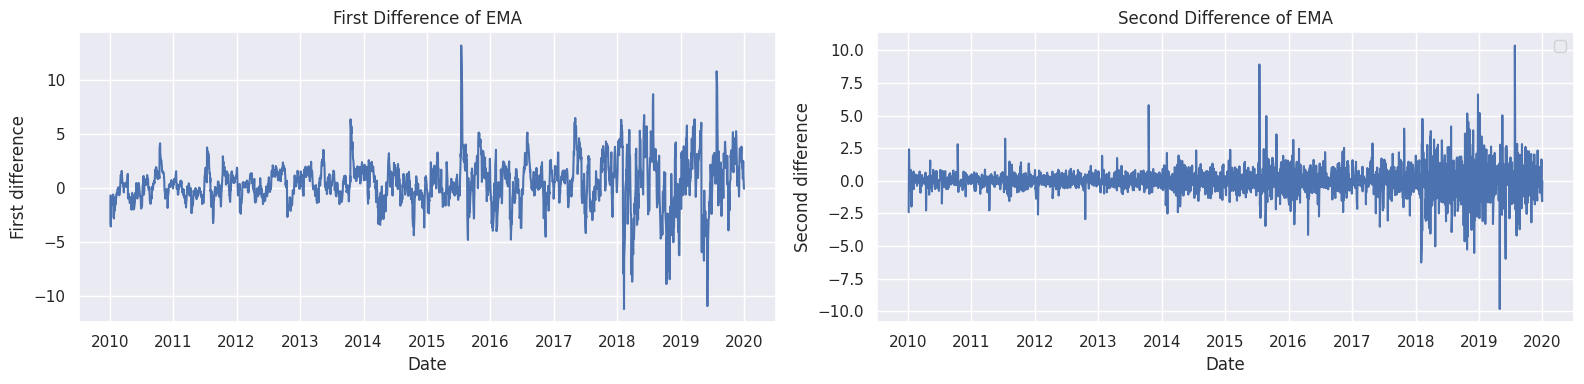

In [32]:
df_copy['EMA second diff'] = df_copy['EMA first diff'].diff()

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_copy,x='Date',y=df_copy['EMA first diff'],ax=ax0)
sns.lineplot(data=df_copy,x='Date',y=df_copy['EMA second diff'],ax=ax1)

ax0.set(ylabel='First difference',title='First Difference of EMA')
ax1.set(ylabel='Second difference',title='Second Difference of EMA')

plt.legend()

plt.tight_layout()
plt.show()

#### It can clearly seen that the second difference timeseries has random fluctuations around a stationary mean and hence, we need to fit an ARIMA(m,2,n) type model on the EMA timeseries.

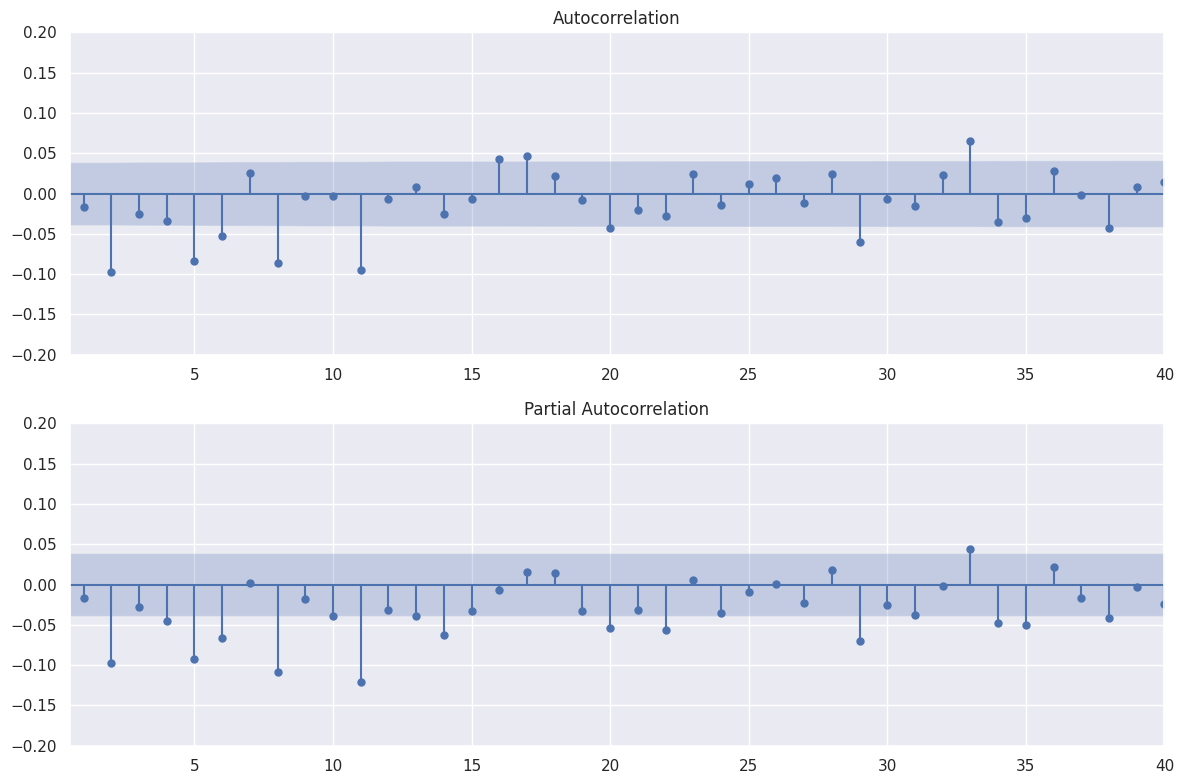

In [60]:
feature = 'EMA second diff'

fig = plt.figure(figsize=(12, 8))
ax0 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_copy[feature].iloc[2:], lags=40, ax=ax0)
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_copy[feature].iloc[2:], lags=40, ax=ax1)

ax0.set(xlim=[0.5,40],ylim=[-0.2,0.2])
ax1.set(xlim=[0.5,40],ylim=[-0.2,0.2])

plt.tight_layout()
plt.show()

#### As before, no clear indication could be obtained. However, the PACF goes to zero at the 6th node and we shall proceed with a ARIMA(6,2,0) model.

In [33]:
split_index = int(df_copy.shape[0]*optimum_split_ratio)

train_arima = df_copy['EMA'].iloc[:split_index]
test_arima = df_copy['EMA'].iloc[split_index:]

model_arima = ARIMA(train_arima,order=(6,2,0)).fit()
model_auto_arima = pm.auto_arima(train_arima,stepwise=False,seasonal=False)
predictions_arima = model_arima.forecast(steps=len(test_arima))
predictions_auto_arima = model_auto_arima.predict(n_periods=len(test_arima))

In [34]:
model_auto_arima

ARIMA(order=(0, 2, 5), scoring_args={}, suppress_warnings=True)

#### The autoarima module fits an ARIMA(0,2,5) model.

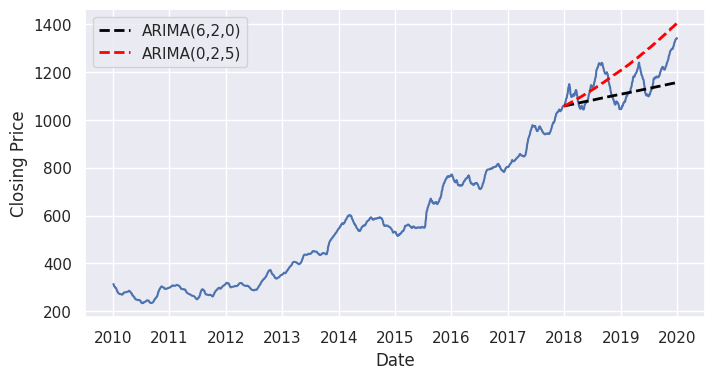

In [35]:
plt.figure(figsize=(8,4))

plt.plot(df_copy['Date'],df_copy['EMA'])
plt.plot(df_copy['Date'].iloc[split_index:], predictions_arima,ls='dashed',lw=2,color='black',label='ARIMA(6,2,0)')
plt.plot(df_copy['Date'].iloc[split_index:], predictions_auto_arima,ls='dashed',lw=2,color='red',label='ARIMA(0,2,5)')

plt.gca().set(xlabel='Date',ylabel='Closing Price')
plt.legend()

plt.show()

#### Both the ARIMA models capture the upward trend to some extent, although the ARIMA(6,2,0) undershoots it and ARIMA(0,2,5) overshoots it. However, since the observed curve was a smoothened curve, ARIMA is expected to do a better job. Hence, our recommendation would be to apply ARIMA to model the averaged price timeseries, rather than the actual price data.

In [45]:
loss_ARIMA_EMA = mse_loss(test_arima,predictions_arima)
loss_auto_ARIMA_EMA = mse_loss(test_arima,predictions_auto_arima)

print(f'The error in the ARIMA(6,2,0) model : {loss_ARIMA_EMA}')
print(f'The error in the Auto ARIMA model : {loss_auto_ARIMA_EMA}')

The error in the ARIMA(6,2,0) model : 74.16473847088446
The error in the Auto ARIMA model : 101.58886220711588


In [46]:
loss_dict = {}

loss_dict['Our ARIMA'] = pd.Series([loss_ARIMA,loss_ARIMA_EMA],index=['Price','Price (EMA)'])
loss_dict['Auto ARIMA'] = pd.Series([loss_auto_ARIMA,loss_auto_ARIMA_EMA],index=['Price','Price (EMA)'])

pd.DataFrame(loss_dict)

,Our ARIMA,Auto ARIMA
Price,129.307187,69.007675
Price (EMA),74.164738,101.588862


#### As expected, our estimated ARIMA models do a better job on the EMA curves, whereas the loss of the autoarima module increases for the EMA curve. This is due to the overshooting, that we observed earlier. However, in the next section, we try a well-known neural network, called Long Short Term Memory (LSTM) network, which is used primarily for timeseries prediction.

## LSTM Neural Network

#### As before, we shall test our model on the closing price, as well as the EMA of closing price. Further, rather than working with the prices, we shall consider the timeseries of daily return of the stock. LSTM works better on returns.

In [38]:
df_copy['EMA Return'] = df_copy['EMA'] / df_copy['EMA'].shift(1)
df_copy = df_copy[1:].reset_index(drop=True)
df_copy.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return,SMA(12),EMA,EMA first diff,EMA second diff,EMA Return
0,2010-01-05,313.903900,314.234222,311.081085,312.307312,6003391,-1.381378,0.995596,-0.004413,NaN,312.963467,-0.725223,NaN,0.997688
1,2010-01-06,313.243256,313.243256,303.483490,304.434448,7949443,-7.872864,0.974791,-0.025532,NaN,309.831662,-3.131804,-2.406581,0.989993
2,2010-01-07,305.005005,305.305298,296.621613,297.347351,12815771,-7.087097,0.976720,-0.023555,NaN,306.227634,-3.604028,-0.472223,0.988368
3,2010-01-08,296.296295,301.926941,294.849854,301.311310,9439151,3.963959,1.013331,0.013243,NaN,305.038417,-1.189217,2.414811,0.996117
4,2010-01-11,302.532532,302.532532,297.317322,300.855865,14411374,-0.455445,0.998488,-0.001513,NaN,304.156090,-0.882328,0.306890,0.997107


#### We begin with the timeseries of daily return. To create multiple training data, we use the sliding window technique. The window size we choose is 20, which is equal to the typical number of trading days in a month.

In [39]:
## Parameters

nrows = df_copy.shape[0]
horizon = 1
train_split_ratio = 0.8

## Hyperparameters

WINDOW_SIZE = 20
NUM_LAYERS = 16 ## number of parallel LSTM layers.
DROPOUT = 0.2

## scaling

feature = 'Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

Train shape: (2012,)
Validation shape: (503,)


In [40]:
def create_sequences_for_lstm(data, window_size, horizon):
    """
    Creates sequences and targets from time series data.
    Input data shape: (n_series, n_steps)
    Output X shape: (n_samples, window_size, 1) ## LSTM needs 3D input
    Output y shape: (n_samples, window_size, 1) ## For timedistributed
    """
    X, y = [], []
    n_steps = data.shape[0]
    for j in range(n_steps - window_size):
        window = data[j:(j + window_size)]
        target = data[(j + horizon):(j + window_size + horizon)]
        X.append(window)
        y.append(target)

    # Reshaping X to be 3D for LSTM: (n_samples, window_size, n_features=1)
    return np.array(X).reshape(-1, window_size, 1), np.array(y).reshape(-1,window_size,1)


## Creating training and validation sets

X_train, y_train = create_sequences_for_lstm(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_sequences_for_lstm(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (1992, 20, 1), y_train shape: (1992, 20, 1)
X_val shape: (483, 20, 1), y_val shape: (483, 20, 1)


### The LSTM model

In [41]:
inputs = Input(shape=(WINDOW_SIZE, 1),name='time_series_input')

## First LSTM layer
x = LSTM(units=NUM_LAYERS,return_sequences=True,name='LSTM_layer')(inputs)

# Dropout Layer
x = Dropout(DROPOUT,name='Dropout_layer')(x)

## Additional LSTM layer (if needed)
#x = LSTM(units=16,return_sequences=True,name='LSTM_layer2')(x)

# Output Layer (Dense)
# units = HORIZON because we predict HORIZON steps for 1 feature
# Linear activation for regression
outputs = TimeDistributed(Dense(units=horizon, activation='linear'),name='output_layer')(x)

# Creating the Model instance
LSTMmodel = Model(inputs=inputs, outputs=outputs, name='lstm_forecaster')

# --- Compiling the Model ---

# learning schedule for the optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Adam is used as the optimizer
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

LSTMmodel.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

LSTMmodel.summary()

Model: "lstm_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_series_input (InputLayer)  │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer (LSTM)               │ (None, 20, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_layer (Dropout)         │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (TimeDistributed)  │ (None, 20, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
start = time.time()

BATCH_SIZE = 200

early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True)

history = LSTMmodel.fit(X_train, y_train,
                    epochs=100,  # 100 epochs was enough for our case
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    #callbacks=[early_stopping], # Add early stopping callback
                    shuffle=True, # Shuffle training windows each epoch
                    verbose=0
                    )

end = time.time()

print(f"Training finished. Time elapsed: {(end-start)} seconds.")

Training finished. Time elapsed: 20.394071102142334 seconds.


In [43]:
y_pred = LSTMmodel.predict(X_val)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


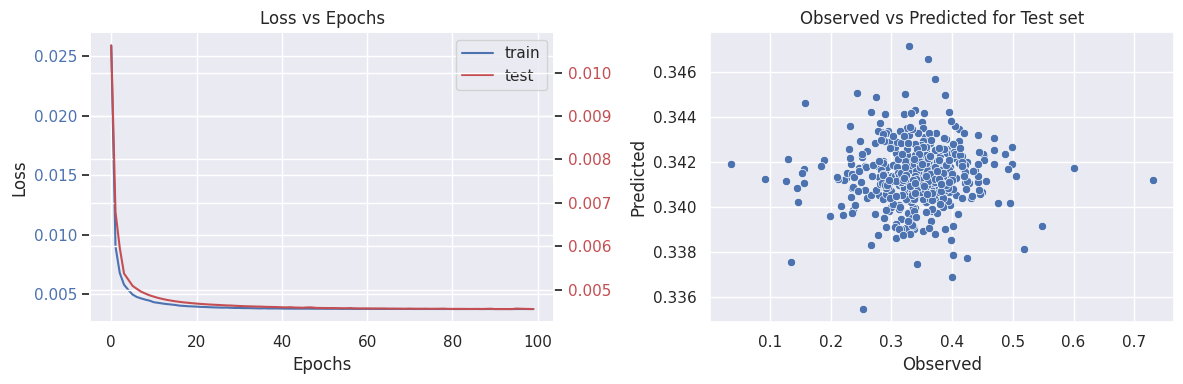

In [44]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
ax2 = ax0.twinx()

ln1 = sns.lineplot(x=history.epoch,y=history.history['loss'],color='b',ax=ax0)
ln2 = sns.lineplot(x=history.epoch,y=history.history['val_loss'],color='r',ax=ax2)

sns.scatterplot(x=y_val[:,-1,0],y=y_pred[:,-1,0],ax=ax1)
ax1.set(xlabel='Observed',ylabel='Predicted',title='Observed vs Predicted for Test set')

lns = ln1.lines+ln2.lines
labs = ['train', 'test']
ax0.legend(lns, labs, loc=0)
ax0.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax0.set(title='Loss vs Epochs',xlabel='Epochs',ylabel='Loss')

plt.tight_layout()
plt.show()

#### As we can see, the model although reached a plateau in terms of both training and test losses, it did not a good job in terms of prediction. Hence, we now work with the daily return of the EMA of the stock price.

In [45]:
## scaling

feature = 'EMA Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

## Creating training and validation sets

X_train, y_train = create_sequences_for_lstm(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_sequences_for_lstm(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train shape: (2012,)
Validation shape: (503,)
X_train shape: (1992, 20, 1), y_train shape: (1992, 20, 1)
X_val shape: (483, 20, 1), y_val shape: (483, 20, 1)


In [46]:
LSTMmodel.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

start = time.time()

BATCH_SIZE = 200

early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True)

history = LSTMmodel.fit(X_train, y_train,
                    epochs=100,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    #callbacks=[early_stopping], # Early stopping callback
                    shuffle=True, # Shuffle training windows each epoch
                    verbose=0
                    )

end = time.time()

print(f"Training finished. Time elapsed: {(end-start)} seconds.")

Training finished. Time elapsed: 19.881999254226685 seconds.


In [47]:
y_pred_EMA = LSTMmodel.predict(X_val)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


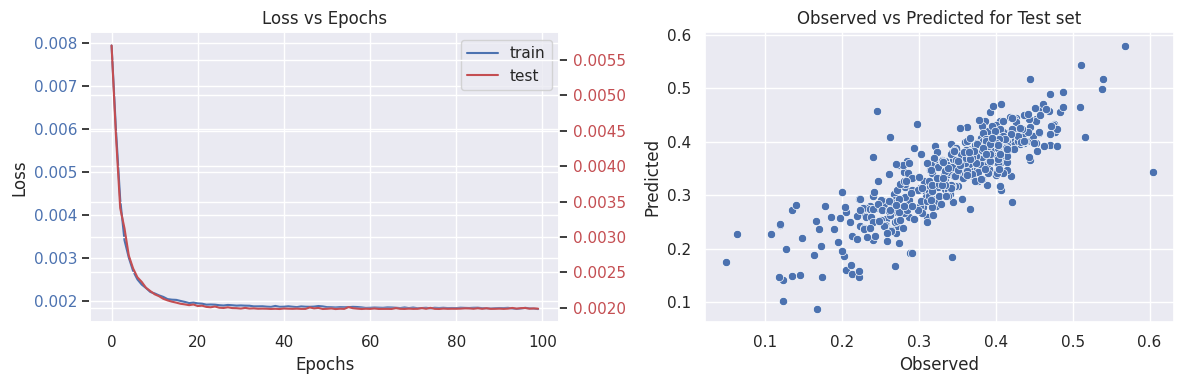

In [48]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
ax2 = ax0.twinx()

ln1 = sns.lineplot(x=history.epoch,y=history.history['loss'],color='b',ax=ax0)
ln2 = sns.lineplot(x=history.epoch,y=history.history['val_loss'],color='r',ax=ax2)

sns.scatterplot(x=y_val[:,-1,0],y=y_pred_EMA[:,-1,0],ax=ax1)
ax1.set(xlabel='Observed',ylabel='Predicted',title='Observed vs Predicted for Test set')

lns = ln1.lines+ln2.lines
labs = ['train', 'test']
ax0.legend(lns, labs, loc=0)
ax0.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax0.set(title='Loss vs Epochs',xlabel='Epochs',ylabel='Loss')

plt.tight_layout()
plt.show()

#### Working with the EMA rather than the actual closing prices, we get both minimum loss and a very good performance in terms of prediction.

In [49]:
y_pred_actual_EMA = scaler.inverse_transform(y_pred_EMA[:,-1,0].reshape(-1,1)).flatten() ## transform back the timeseries

y_forecast_EMA = y_pred_actual_EMA * df_copy['EMA'].shift(1).iloc[-len(y_pred_actual_EMA):]  ## convert back from EMA returns to the EMA

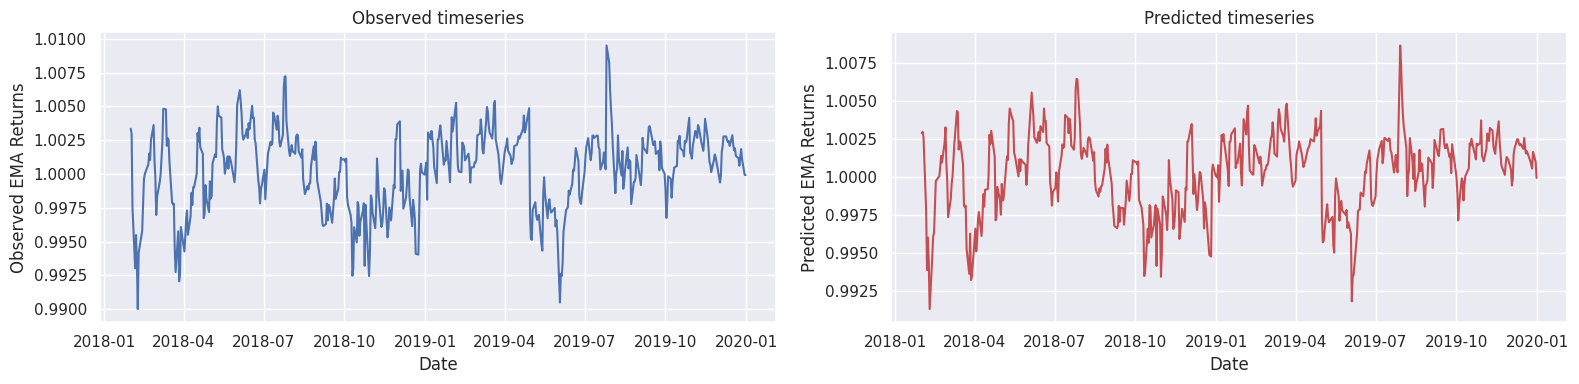

In [52]:
horizon_ahead = len(y_forecast_EMA)

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=df_copy['EMA Return'].iloc[-horizon_ahead:],ax=ax[0],color='b')
sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=y_pred_actual_EMA,ax=ax[1],color='r')

ax[0].set(ylabel='Observed EMA Returns',title='Observed timeseries')
ax[1].set(ylabel='Predicted EMA Returns',title='Predicted timeseries')

plt.tight_layout()
plt.show()

#### As we can see, the LSTM does a good job in capturing even the short-time flutuations in the EMA returns timeseries.

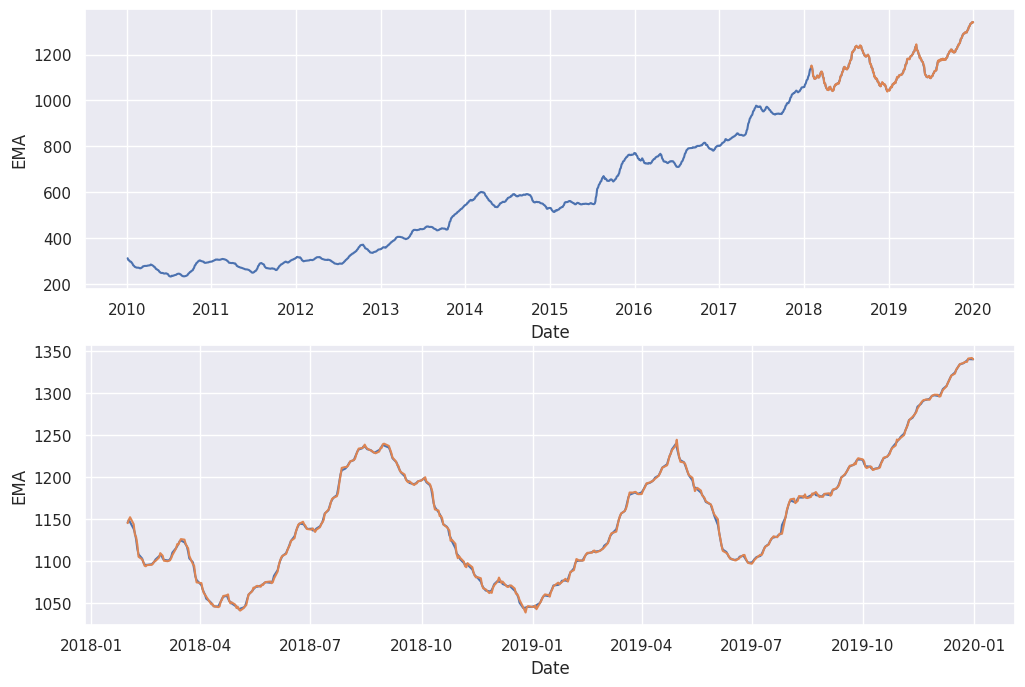

In [62]:
horizon_ahead = len(y_forecast)

fig,ax = plt.subplots(2,1,figsize=(12,8))

sns.lineplot(x=df_copy['Date'],y=df_copy['EMA'],ax=ax[0])
sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=y_forecast,ax=ax[0])

sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=df_copy['EMA'].iloc[-horizon_ahead:],ax=ax[1])
sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=y_forecast_EMA,ax=ax[1])

plt.show()

#### Since the LSTM captured the fluctuations in the EMA returns with a very high accuracy, it is expected that converting back to a EMA timeseries we will have excellent overlap with the observed data.

In [63]:
loss_LSTM = mse_loss(df_copy.EMA.iloc[-horizon_ahead:],y_forecast_EMA)
print(f'The error in the LSTM model : {loss_LSTM}')

The error in the LSTM model : 1.7793940186166513


In [65]:
improvement_factor = (loss_ARIMA - loss_LSTM) / loss_ARIMA

print(f'Prediction with LSTM model shows an improvement of {round(improvement_factor*100,2)}%')

Prediction with LSTM model shows an improvement of 98.62%


### A significant $\sim 98\% $ reduction of error obtained using the LSTM on the returns of the EMA of the closing prices, rather than on the actual returns. The above plot shows that LSTM captures even the short-term fluctuations in the test dataset very well, thus rendering a highly reduced loss.

# ----- Unfinished analysis -----

## LSTM with attention

In [53]:
## scaling

feature = 'EMA Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

## Creating training and validation sets

X_train, y_train = create_sequences_for_lstm(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_sequences_for_lstm(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train shape: (2012,)
Validation shape: (503,)
X_train shape: (1992, 20, 1), y_train shape: (1992, 20, 1)
X_val shape: (483, 20, 1), y_val shape: (483, 20, 1)


In [54]:
testdat = X_train[:2,:,:]

y0,y1 = Attention()([testdat,testdat],return_attention_scores=True)

y0.shape,y1.shape,tf.reduce_mean(y1,axis=1).shape

(TensorShape([2, 20, 1]), TensorShape([2, 20, 20]), TensorShape([2, 20]))

In [45]:
Dense(units=1,activation=None)(testdat).shape

TensorShape([2, 20, 1])

In [55]:
# Adding LSTM layers with return_sequences=True
inputs = Input(shape=(WINDOW_SIZE, 1),name='time_series_input')

q_input = Dense(units=horizon,name='query')(inputs)
k_input = Dense(units=horizon,name='key')(inputs)
v_input = Dense(units=horizon,name='value')(inputs)

x_attn = Attention(name='Attention_layer')([q_input,v_input,k_input])

x = LSTM(units=32,return_sequences=True,name='LSTM_layer')(x_attn)

x = Dropout(DROPOUT,name='Dropout_layer')(x)

#x = BatchNormalization(name='batch_norm')(x)

outputs = TimeDistributed(Dense(units=horizon, activation=None),name='output_layer')(x)

lstmAttnModel = Model(inputs=inputs, outputs=outputs, name='lstm_forecaster')

# --- Compiling the Model ---

# learning schedule for the optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Adam is used as the optimizer
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

lstmAttnModel.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

lstmAttnModel.summary()

Model: "lstm_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ query (Dense)       │ (None, 20, 1)     │          2 │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value (Dense)       │ (None, 20, 1)     │          2 │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ key (Dense)         │ (None, 20, 1)     │          2 │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_layer     │ (None, 20, 1)     │          0 │ query[0][0],      │
│ (Attention)         │                   │            │ value[0][0],      │
│                     │                   │            │ key[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_layer (LSTM)   │ (None, 20, 32)    │      4,352 │ Attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_layer       │ (None, 20, 32)    │          0 │ LSTM_layer[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 20, 1)     │         33 │ Dropout_layer[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,391 (17.15 KB)

 Trainable params: 4,391 (17.15 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
start = time.time()

BATCH_SIZE = 200

early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=10,        # Stop after 10 epochs with no improvement
                               restore_best_weights=True)

history = lstmAttnModel.fit(X_train, y_train,
                    epochs=100,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    #callbacks=[early_stopping], # Early stopping callback
                    shuffle=True, # Shuffle training windows each epoch
                    verbose=0
                    )

end = time.time()

print(f"Training finished. Time elapsed: {(end-start)} seconds.")

Training finished. Time elapsed: 24.94180965423584 seconds.


In [57]:
test_loss = lstmAttnModel.evaluate(X_val,y_val)
dict(zip(lstmAttnModel.metrics_names, test_loss))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0433


{'loss': 0.0025209374725818634, 'compile_metrics': 0.0392695814371109}

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


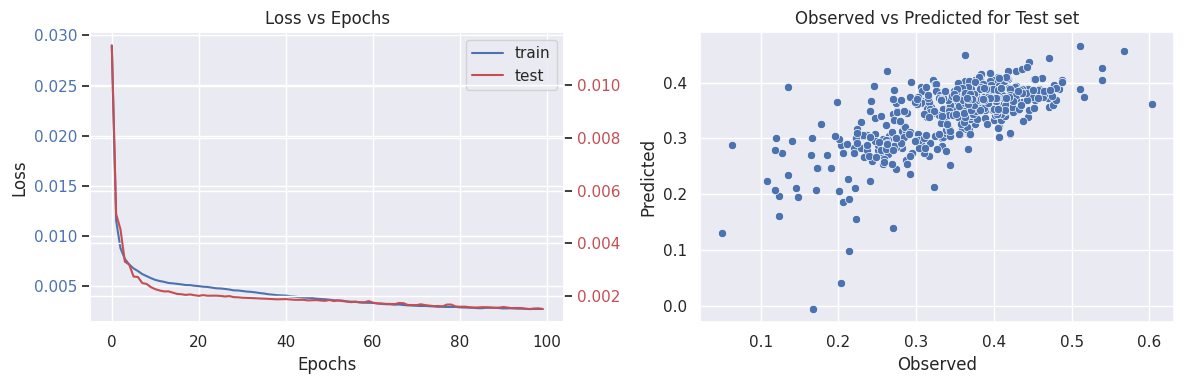

In [58]:
y_pred = lstmAttnModel.predict(X_val)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,4))
ax2 = ax0.twinx()

ln1 = sns.lineplot(x=history.epoch,y=history.history['loss'],color='b',ax=ax0)
ln2 = sns.lineplot(x=history.epoch,y=history.history['val_loss'],color='r',ax=ax2)

sns.scatterplot(x=y_val[:,-1,0],y=y_pred[:,-1,0],ax=ax1)
ax1.set(xlabel='Observed',ylabel='Predicted',title='Observed vs Predicted for Test set')

lns = ln1.lines+ln2.lines
labs = ['train', 'test']
ax0.legend(lns, labs, loc=0)
ax0.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax0.set(title='Loss vs Epochs',xlabel='Epochs',ylabel='Loss')

plt.tight_layout()
plt.show()

In [59]:
y_pred_actual = scaler.inverse_transform(y_pred[:,-1,0].reshape(-1,1)).flatten() ## transform back the timeseries

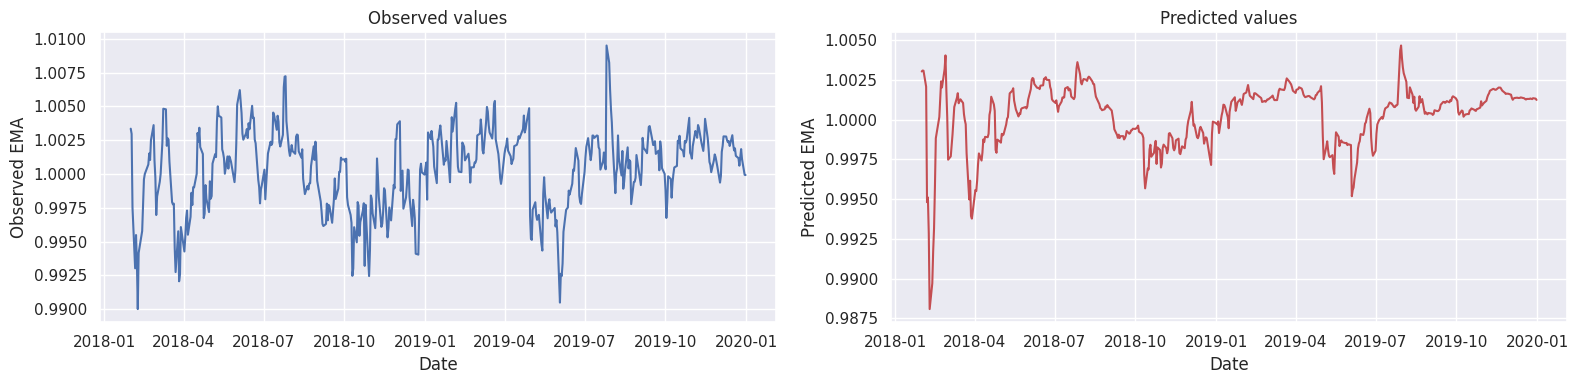

In [60]:
horizon_ahead = len(y_pred_actual)

fig,ax = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=df_copy['EMA Return'].iloc[-horizon_ahead:],ax=ax[0],color='b')
sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=y_pred_actual,ax=ax[1],color='r')

ax[0].set(ylabel='Observed EMA',title='Observed values')
ax[1].set(ylabel='Predicted EMA',title='Predicted values')

plt.tight_layout()
#plt.savefig('output.png',dpi=200)

plt.show()

In [150]:
predicted_prices = []
current_batch = np.array(df_copy['EMA Return'].iloc[-WINDOW_SIZE:])
scaler = MinMaxScaler()
scaled_batch = scaler.fit_transform(current_batch.reshape(-1,1)).flatten()

current_batch = scaled_batch.reshape(1, WINDOW_SIZE, 1)  # Most recent observations
horizon_ahead = 5
for i in range(horizon_ahead):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = lstmAttnModel.predict(current_batch)
    
    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction[:,-1,0].reshape(1, 1, 1)
    
    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
    # Inverse transform the prediction to the original price scale
    predicted_prices.append(next_prediction[:,-1,0])

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1,1)).flatten()

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Stock Prices for the next 4 days:  [0.99947083 0.9989654  0.9984436  0.9979109  0.99736655]


In [152]:
df_comp_mask = df['Date'].dt.year >= 2019

df_comp = df[df_comp_mask]
df_comp['EMA'] = df_comp['Close'].ewm(span=20,adjust=True).mean()
df_comp['EMA Return'] = df_comp['EMA'] / df_comp['EMA'].shift(1)

df_comp = df_comp[df_comp['Date'] >= df_copy['Date'].iloc[-WINDOW_SIZE]]

df_comp.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return,EMA,EMA Return
3848,2019-12-03,1278.660034,1297.229980,1277.050049,1294.739990,1263500,5.880005,1.004562,0.004552,1296.452950,0.999861
3849,2019-12-04,1306.099976,1324.270020,1303.050049,1318.939941,1775300,24.199951,1.018691,0.018518,1298.594568,1.001652
3850,2019-12-05,1327.000000,1327.979980,1314.319946,1326.959961,1220400,8.020020,1.006081,0.006062,1301.296034,1.002080
3851,2019-12-06,1332.750000,1342.469971,1331.229980,1339.390015,1648400,12.430054,1.009367,0.009324,1304.924032,1.002788
3852,2019-12-09,1338.859985,1357.550049,1336.069946,1342.989990,1542100,3.599975,1.002688,0.002684,1308.549362,1.002778


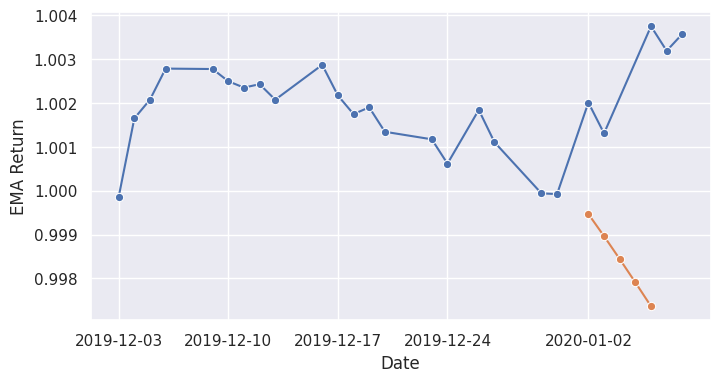

In [153]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

last_date = df_copy['Date'].iloc[-1]
next_day = last_date + pd.Timedelta(days=2)
prediction_dates = pd.date_range(start=next_day, periods=horizon_ahead)


sns.lineplot(x=df_comp['Date'].iloc[:WINDOW_SIZE+horizon_ahead],y=df_comp['EMA Return'].iloc[:WINDOW_SIZE+horizon_ahead],marker='o',ax=ax)
sns.lineplot(x=prediction_dates,y=predicted_prices,marker='o',ax=ax)

plotdates = list(df_copy['Date'].iloc[-WINDOW_SIZE:]) + list(prediction_dates)
ax.set(xticks= plotdates[::5])

plt.show()

## Kolgomorov-Arnold Network (KAN) model

In [113]:
feature = 'EMA'
scaler = MinMaxScaler()
df_kan_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()
df_kan_scaled.shape

(2515,)

In [114]:
window_size = 20
horizon = 1
train_split_ratio = 0.8

X, y = [], []
n_steps = len(df_kan_scaled)
for j in range(n_steps - window_size):
    window = df_kan_scaled[j:(j + window_size)]
    target = df_kan_scaled[(j + window_size):(j + window_size + horizon)]
    X.append(window)
    y.append(target)

X = torch.tensor(X,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.float32).flatten()

ncols = X.shape[0]
split_index = int(ncols * train_split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index].reshape(-1,1), y[split_index:].reshape(-1,1)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_test.shape}, y_val shape: {y_test.shape}")

X_train shape: torch.Size([1996, 20]), y_train shape: torch.Size([1996, 1])
X_val shape: torch.Size([499, 20]), y_val shape: torch.Size([499, 1])


### Simplistic KAN module

In [115]:
class KolmogorovArnoldNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.decomposition = nn.Linear(input_dim, hidden_dim)
        self.aggregation = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.tanh(self.decomposition(x))
        return self.aggregation(h)


In [116]:
model = KolmogorovArnoldNetwork(window_size, 20, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [117]:
start = time.time()

loss_data = []

for epoch in range(100):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss_data.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(f'epoch {epoch}: finished')

end = time.time()

print(f"time elapsed: {end-start} seconds.")

time elapsed: 0.1538553237915039 seconds.


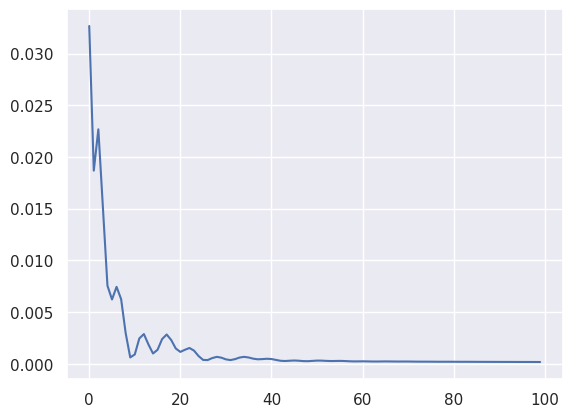

In [118]:
plt.plot(range(100),loss_data)

In [119]:
model.eval()
with torch.no_grad():
    predictions_kan = model(X_test).numpy()
    predictions_kan = scaler.inverse_transform(predictions_kan)
    y_test_actual = scaler.inverse_transform(y_test)

In [ ]:
y_test.shape

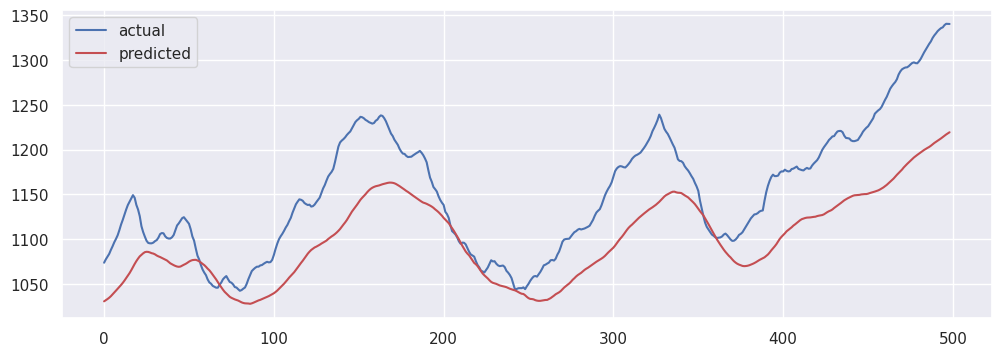

In [120]:
fig,ax = plt.subplots(1,1,figsize=(12,4))

sns.lineplot(x=np.arange(len(y_test_actual)),y=y_test_actual.flatten(),label='actual',ax=ax)
sns.lineplot(x=np.arange(len(y_test_actual)),y=predictions_kan.flatten(),c='r',label='predicted',ax=ax)

#sns.scatterplot(x=y_test_actual.flatten(),y=predictions_kan.flatten(),s=6,c='r',ax=ax1)

plt.show()

In [125]:
horizon_ahead = len(y_val) - window_size
last_known_scaled = df_kan_scaled[-horizon_ahead-window_size:-horizon_ahead]
forecast_scaled = []

model.eval()
with torch.no_grad():
    for _ in range(horizon_ahead):
        input_tensor = torch.tensor(last_known_scaled,dtype=torch.float32)
        pred = model(input_tensor).item()
        forecast_scaled.append(pred)
        last_known_scaled = np.append(last_known_scaled[1:], pred)

forecast_unscaled = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()


In [122]:
df_kan_actual = scaler.inverse_transform(df_kan_scaled.reshape(-1,1)).flatten()

#plot_data = list(df_kan_actual)

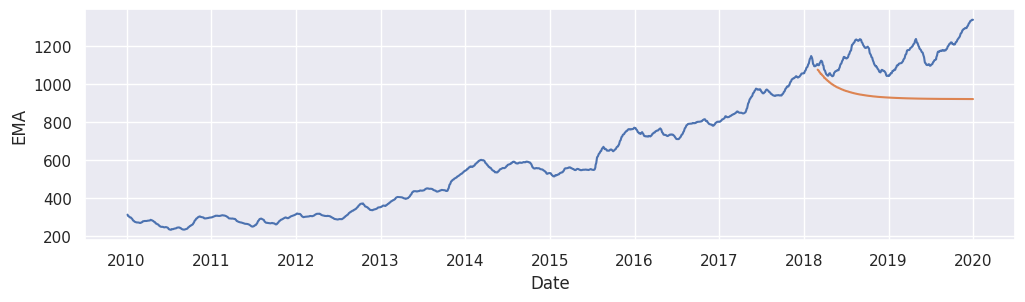

In [129]:
fig,ax = plt.subplots(1,1,figsize=(12,3))

sns.lineplot(x=df_copy['Date'],y=df_copy['EMA'],ax=ax)
sns.lineplot(x=df_copy['Date'].iloc[-horizon_ahead:],y=forecast_unscaled,ax=ax)

plt.show()

### Pykan module

In [ ]:
kanmodel = KAN(width=[3,5,5,3,1], grid=3, k=3, seed=0)

In [ ]:
dataset = {}

dataset['train_input'] = X_train
dataset['test_input'] = X_test
dataset['train_label'] = y_train
dataset['test_label'] = y_test

X = dataset['train_input']
y = dataset['train_label']

In [ ]:
kanmodel(dataset['train_input']);
kanmodel.plot()

In [ ]:
def train_acc():
    loss = nn.MSELoss()
    return loss(kanmodel(dataset['train_input']),dataset['train_label'])

def test_acc():
    loss = nn.MSELoss()
    return loss(kanmodel(dataset['test_input']), dataset['test_label'])

In [ ]:
kanmodel.fit(dataset, opt='LBFGS', steps=20, metrics=(train_acc, test_acc), loss_fn=nn.MSELoss());

In [ ]:
kanmodel = kanmodel.prune()
kanmodel.plot()

In [ ]:
kanmodel = kanmodel.prune(node_th = 1e-1)

In [ ]:
kanmodel.fit(dataset, opt='LBFGS', steps=50, metrics=(train_acc, test_acc), loss_fn=nn.MSELoss());

In [ ]:
kanmodel = kanmodel.prune(node_th=1e-1)
kanmodel(dataset['train_input'])
kanmodel.plot()

In [ ]:
y_pred = kanmodel.forward(dataset['test_input']).detach().numpy().flatten()
y_pred.shape,dataset['test_label'].shape

In [ ]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_actual = scaler.inverse_transform(dataset['test_label'].reshape(-1,1)).flatten()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,3))

sns.lineplot(x=np.arange(len(y_pred)),y=y_actual,ax=ax[0])
sns.lineplot(x=np.arange(len(y_pred)),y=y_pred,c='r',ax=ax[1])

plt.show()

## Old analysis

In [ ]:
## Pre Crash era

i1,i2 = 100,701

df['Date'] = pd.to_datetime(df['Date'])

df['SMA(20)'] = df['Open'].rolling(window=20).mean()
df['EMA'] = df['Open'].ewm(span=20,adjust=True).mean()
df['CMA'] = df['Open'].expanding(min_periods=20).mean()

plt.figure(figsize=(9,4))
plt.plot(df['Date'][i1:i2],df.iloc[i1:i2,1])
plt.plot(df['Date'][i1:i2],df['SMA(20)'][i1:i2])
plt.plot(df['Date'][i1:i2],df['EMA'][i1:i2])
plt.plot(df['Date'][i1:i2],df['CMA'][i1:i2])

deltaT = (df['Date'][i2]-df['Date'][i1]).total_seconds()
deltaP = (df['Open'][i2]-df['Open'][i1])
slp = deltaP/deltaT
intrcpt = df['Open'][i1]

plt.gca().plot(df['Date'][i1:i2],intrcpt + slp*(df['Date'][i1:i2] - df['Date'][i1]).dt.total_seconds(),ls='dashed',lw=2)

plt.show()

In [ ]:
meanDrift = (df['Log Gain'][i2] - df['Log Gain'][i1])/(deltaT/(3600*24)) ## unit of time 1 day
meanVolatility = np.sqrt(df['Log Gain'][i1:i2].var())

meanDrift,meanVolatility,deltaT

In [ ]:
dataSMA = df['SMA(20)'][i1:i2].dropna()
id1,id2 = pd.Index(df['SMA(20)']).get_loc(dataSMA.values[0]), pd.Index(df['SMA(20)']).get_loc(dataSMA.values[-1])
deltaT = (df['Date'][id2]-df['Date'][id1]).total_seconds()
deltaP = (dataSMA.values[-1]-dataSMA.values[0])
slp = deltaP/(deltaT/(3600*24))
# slp
deltaT

In [ ]:
df.head()

In [ ]:
def create_noise_array(corrCoeff,N):
    means = [0,0]
    covs = np.ones((2,2))*corrCoeff
    np.fill_diagonal(covs,1)

    return np.random.multivariate_normal(means,covs,size=N).T

def update_stock_price(S0,v0,dT,r,theta,omega,zeta,A,B): ## GARCH model
    v = v0 + theta*(omega - v0)*dT + zeta*v0*B*np.sqrt(dT)
    s = S0 + (r - 0.5*v)*S0*dT + np.sqrt(v*dT)*S0*A
    return s,v

def create_paths(T,rho,S0,V0,dT,r,theta,omega,zeta):
    tlocal = 0
    idx = 1
    NT = int(T.array[-1]/dT)+1
    Sarr,Varr = [S0],[V0]
    s0,v0 = S0,V0
    # Sarr[0],Varr[0] = s0,v0
    Noise = create_noise_array(rho,NT)
    for i in range(1,NT):
        # print(f"s0 = {s0},v0 = {v0}")
        s,v = update_stock_price(s0,v0,dT,r,theta,omega,zeta,Noise[0,i-1],Noise[1,i-1])
        s0,v0 = s,v
        tlocal += dT
        # print(round(tlocal,2))
        # if (round(tlocal,1)==T.array[idx]):
            # print(f"idx is {idx}")
        Sarr.append(s),Varr.append(v)
            # idx += 1
        
        # print(f"s = {s},v = {v}")

    return Sarr,Varr

In [ ]:
T = (df['Date'][i1:i2]-df['Date'][i1]).dt.total_seconds()
T = T[:2]
# T = T.array[::2]
dT = 0.1
S0,V0 = df['Open'][0],meanVolatility
rho = 0.7
r,theta,omega,zeta = 0.03,0.05,0.06,0.05

Sarr,Varr = create_paths(T,rho,S0,V0,dT,r,theta,omega,zeta)
# T.array[1]

In [ ]:
dfS = pd.DataFrame(Sarr,columns=['S'])
dfS['V'] = Varr
dfS['Log Gain'] = dfS['S'].apply(lambda x : np.log(x)).diff()
plt.plot(dfS.iloc[i1:601,1])
# dfS.loc[(dfS['S']<=0)].any()

In [ ]:
ntest = create_noise_array(0.2,10000)
a,b,c = plt.hist(ntest[0,:],bins=100)

In [ ]:
a1 = create_noise_array(0,1000)
at1 = a1[0,:].T
at2 = a1[1,:].T

In [ ]:
np.dot(at1,at2),np.sum(at1**2)

In [ ]:
horizon_ahead = len(y_val[:,-1,0]) - WINDOW_SIZE
last_known_scaled = np.array(df_val_scaled[-horizon_ahead-WINDOW_SIZE:-horizon_ahead])
forecast_scaled = []

for _ in range(horizon_ahead):
    pred = LSTMmodel(last_known_scaled.reshape(-1,WINDOW_SIZE,1)).numpy()[:,-1,0]
    forecast_scaled.append(pred)
    last_known_scaled = np.append(last_known_scaled[1:], pred)

forecast_unscaled = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_EMA = forecast_unscaled * df_copy['EMA'].shift(1).iloc[-horizon_ahead:]

### Additional analysis

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

sns.lineplot(data=df,x='Date',y='Log Return',ax=ax)

meanGain,stdGain = df['Log Return'].mean(),np.sqrt(df['Log Return'].var())
seMeanGain = stdGain/np.sqrt(df.shape[0])
seForecastGain = np.sqrt(stdGain**2 + seMeanGain**2)

gP95,gM95 = meanGain + 2.093*seForecastGain, meanGain - 2.093*seForecastGain
gP50,gM50 = meanGain + 0.688*seForecastGain, meanGain - 0.688*seForecastGain

ax.axhline(gP95,color='red',ls='dashed',lw=2,label='95% confidence lines')
ax.axhline(gM95,color='red',ls='dashed',lw=2)

ax.set(title='Log Return of the stock')

plt.legend()

plt.show()

#### Too many observations outside 95% confidence interval, which are calculated under the assumption that the gains are independent and are distributed normally. Therefore, there are two possibilities. The most logical guess would be that the gains are not independent (volatility clustering).

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

sns.histplot(data=df,x='Log Return',kde=True,bins=100,ax=ax)

ax.set(title='Distribution of log return of the stock')

plt.show()